In [1]:
trainingOHCA_fileName = "generatedPoints1_100000.csv"
candidateAED_fileName = "Singapore buildings locations.xlsx"
testOHCA_fileName ="generatedPoints2_100000.csv"
currentAED_fileName = "AED Details_As of 27 March 2019 (2).xlsx"

In [2]:
import json
import pandas as pd
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import pathlib

import numpy as np
from haversine import haversine_vector, Unit
from haversine import haversine
from os import path
import scipy.sparse
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
from pulp import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt     
import seaborn as sns
from itertools import combinations
from sklearn import preprocessing, cluster
from sklearn.metrics import silhouette_score
import scipy
import scipy.cluster
from matplotlib import colors as mcolors
from skimage.io import imread
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification

In [5]:
OHCA = pd.read_csv(trainingOHCA_fileName, names = ["LatOHCA", "LongOHCA"], header = None)
OHCA.head()

,LatOHCA,LongOHCA
0,1.403902,103.857553
1,1.299905,103.820317
2,1.325750,103.721845
3,1.291553,103.801827
4,1.342320,103.692338


In [7]:
OHCA_gdf = gpd.GeoDataFrame(OHCA, geometry=gpd.points_from_xy(OHCA.LongOHCA,OHCA.LatOHCA))
OHCA_gdf.head()

,LatOHCA,LongOHCA,geometry
0,1.403902,103.857553,POINT (103.85755 1.40390)
1,1.299905,103.820317,POINT (103.82032 1.29990)
2,1.325750,103.721845,POINT (103.72184 1.32575)
3,1.291553,103.801827,POINT (103.80183 1.29155)
4,1.342320,103.692338,POINT (103.69234 1.34232)


In [6]:
candidateAED = pd.read_excel(candidateAED_fileName)
candidateAED.columns = ["LatAED","LongAED"]
candidateAED.head()

,LatAED,LongAED
0,1.275829,103.849576
1,1.274950,103.851665
2,1.279587,103.868956
3,1.273682,103.860075
4,1.279785,103.851529


In [8]:
candidateAED_gdf = gpd.GeoDataFrame(candidateAED, geometry=gpd.points_from_xy(candidateAED.LongAED,candidateAED.LatAED))
candidateAED_gdf.head()

,LatAED,LongAED,geometry
0,1.275829,103.849576,POINT (103.84958 1.27583)
1,1.274950,103.851665,POINT (103.85167 1.27495)
2,1.279587,103.868956,POINT (103.86896 1.27959)
3,1.273682,103.860075,POINT (103.86008 1.27368)
4,1.279785,103.851529,POINT (103.85153 1.27978)


In [12]:
currentAED = pd.read_csv(currentAED_fileName)
currentAED.columns = ["Postal Code","LatAED","LongAED"]
currentAED_gdf = gpd.GeoDataFrame(currentAED, geometry=gpd.points_from_xy(currentAED.LongAED,currentAED.LatAED))
currentAED.head()

,Postal Code,LatAED,LongAED,geometry
0,498770,1.352654,103.973217,POINT (103.97322 1.35265)
1,680486,1.375489,103.738288,POINT (103.73829 1.37549)
2,680752,1.392346,103.747409,POINT (103.74741 1.39235)
3,680754,1.392310,103.746518,POINT (103.74652 1.39231)
4,680756,1.392493,103.745591,POINT (103.74559 1.39249)


In [21]:
testOHCA = pd.read_csv("generatedPoints2_100000.csv", names = ["LatOHCA", "LongOHCA"], header = None)
testOHCA.head()

,LatOHCA,LongOHCA
0,1.274002,103.795127
1,1.347061,103.968633
2,1.334520,103.753447
3,1.363367,103.875963
4,1.458081,103.826529


In [22]:
testOHCA_gdf = gpd.GeoDataFrame(testOHCA, geometry=gpd.points_from_xy(testOHCA.LongOHCA,testOHCA.LatOHCA))
testOHCA_gdf.head()

,LatOHCA,LongOHCA,geometry
0,1.274002,103.795127,POINT (103.79513 1.27400)
1,1.347061,103.968633,POINT (103.96863 1.34706)
2,1.334520,103.753447,POINT (103.75345 1.33452)
3,1.363367,103.875963,POINT (103.87596 1.36337)
4,1.458081,103.826529,POINT (103.82653 1.45808)


## Map points to subzone

In [8]:
subzone = gpd.read_file('D:/MyDownloads/master-plan-2019-subzone-boundary-no-sea-geojson.geojson')
subzone.head()

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.88025 1.28386 0.00000, 103.880..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83764 1.29560 0.00000, 103.837..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83410 1.29248 0.00000, 103.834..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((103.71253 1.29163 0.00000, 1..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84718 1.29700 0.00000, 103.847..."


In [9]:
subzone['SUBZONE_ID'] = subzone['Name'].apply(lambda x: x.split('_')[-1])
subzone['SUBZONE_N'] = subzone['Description'].apply(lambda x: x.split('SUBZONE_N</th> <td>')[1])
subzone['SUBZONE_N'] = subzone['SUBZONE_N'].apply(lambda x: x.split('</td> </tr>')[0])
subzone.head()

,Name,Description,geometry,SUBZONE_ID,SUBZONE_N
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.88025 1.28386 0.00000, 103.880...",1,MARINA EAST
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83764 1.29560 0.00000, 103.837...",2,INSTITUTION HILL
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.83410 1.29248 0.00000, 103.834...",3,ROBERTSON QUAY
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((103.71253 1.29163 0.00000, 1...",4,JURONG ISLAND AND BUKOM
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84718 1.29700 0.00000, 103.847...",5,FORT CANNING


<AxesSubplot:>

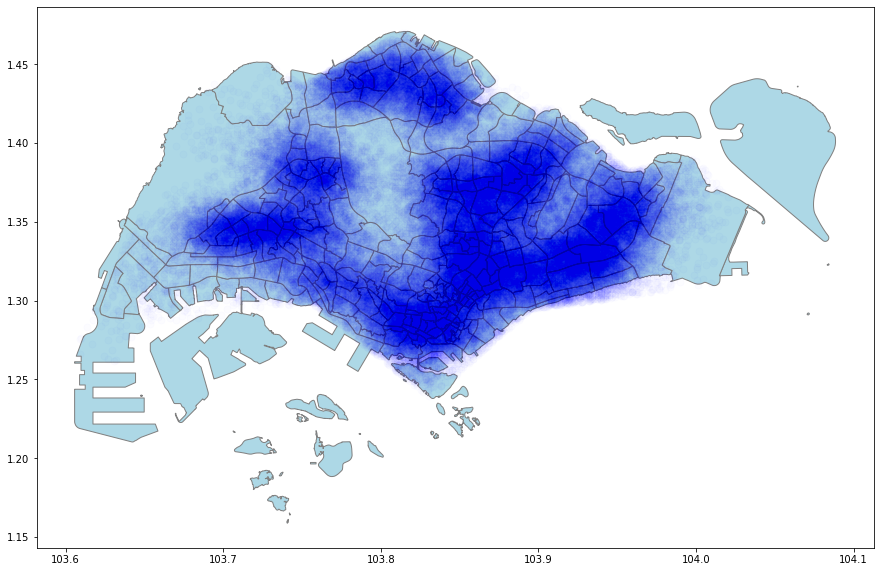

In [39]:
base = subzone.plot(color='lightblue', edgecolor='grey',figsize=(15, 15))
OHCA_gdf.plot(ax=base, color='b', marker="o", markersize=50, alpha=0.01) #

<AxesSubplot:>

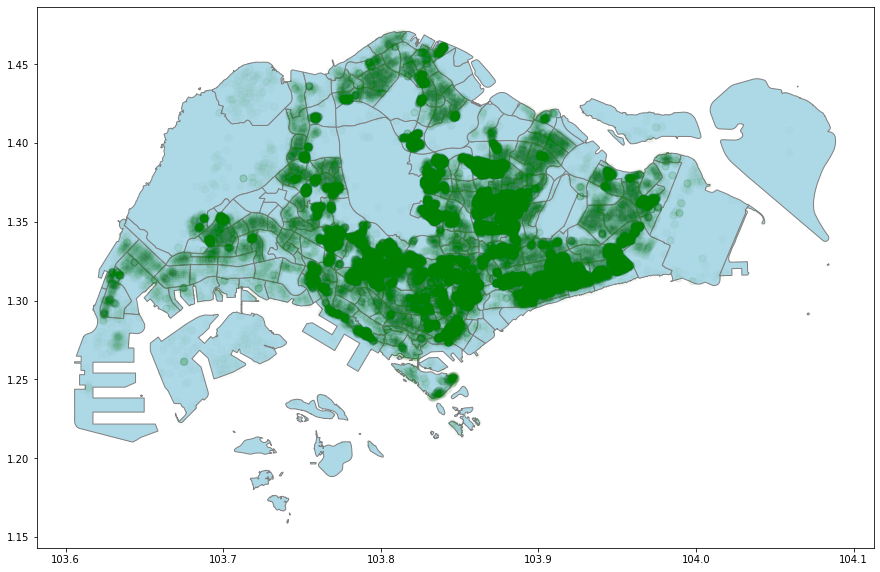

In [44]:
base = subzone.plot(color='lightblue', edgecolor='grey',figsize=(15, 15))
currentAED_gdf.plot(ax=base, color='g', marker="o", markersize=50, alpha=0.01) 

In [11]:
# function that will compare all the events to each polygon
def get_pip1 (gdf, regions):
    r_list = list(regions.SUBZONE_ID)
    #create empty dataframe
    df = pd.DataFrame().reindex_like(gdf).dropna()
    for r in r_list:
        #get geometry for specific region
        pol = (regions.loc[regions.SUBZONE_ID==r])
        pol.reset_index(drop = True, inplace = True)
        #identify those records from gdf that are intersecting with the region polygon
        pip_mask = gdf.within(pol.loc[0, 'geometry'])
        #filter gdf to keep only the intersecting records
        pip_data = gdf.loc[pip_mask].copy()
        #create a new column and assign the region name as the value
        pip_data['region']= r
        #append region data to empty dataframe
        df = df.append(pip_data)

    return df

In [41]:
OHCA_df = get_pip1(OHCA_gdf, subzone)
OHCA_df

,LatOHCA,LongOHCA,geometry,region
1256,1.287694,103.868054,POINT (103.86805 1.28769),1
1466,1.285704,103.875096,POINT (103.87510 1.28570),1
1878,1.285932,103.877285,POINT (103.87728 1.28593),1
2036,1.281577,103.876279,POINT (103.87628 1.28158),1
2288,1.290703,103.865826,POINT (103.86583 1.29070),1
...,...,...,...,...
86530,1.268316,103.629242,POINT (103.62924 1.26832),332
87087,1.288839,103.625416,POINT (103.62542 1.28884),332
89699,1.277422,103.638028,POINT (103.63803 1.27742),332
89902,1.272369,103.616772,POINT (103.61677 1.27237),332


In [43]:
OHCA_df.to_csv('D:\MyDownloads\generatedPoints1_100000_subzone.csv')

In [24]:
currentAED_df = get_pip1(currentAED_gdf, subzone)
currentAED_df = currentAED_df.sort_index()
currentAED_df

,Postal Code,LatAED,LongAED,geometry,region
0,498770,1.352654,103.973217,POINT (103.97322 1.35265),289
1,680486,1.375489,103.738288,POINT (103.73829 1.37549),240
2,680752,1.392346,103.747409,POINT (103.74741 1.39235),256
3,680754,1.392310,103.746518,POINT (103.74652 1.39231),256
4,680756,1.392493,103.745591,POINT (103.74559 1.39249),256
...,...,...,...,...,...
9875,058929,1.282010,103.844418,POINT (103.84442 1.28201),28
9876,218935,1.314315,103.852750,POINT (103.85275 1.31431),128
9877,529903,1.341709,103.953151,POINT (103.95315 1.34171),204
9878,529903,1.341856,103.953814,POINT (103.95381 1.34186),204


In [27]:
currentAED_df.to_csv('D:\MyDownloads\currentAED_subzone.csv')

In [45]:
candidateAED_df = get_pip1(candidateAED_gdf, subzone)
candidateAED_df

,LatAED,LongAED,geometry,region
110,1.283549,103.877910,POINT (103.87791 1.28355),1
60331,1.293043,103.872465,POINT (103.87247 1.29304),1
60332,1.293949,103.868070,POINT (103.86807 1.29395),1
60335,1.292964,103.868401,POINT (103.86840 1.29296),1
61495,1.294632,103.875841,POINT (103.87584 1.29463),1
...,...,...,...,...
113497,1.289424,103.646582,POINT (103.64658 1.28942),332
113499,1.288164,103.633437,POINT (103.63344 1.28816),332
113613,1.288103,103.632541,POINT (103.63254 1.28810),332
113679,1.295899,103.620592,POINT (103.62059 1.29590),332


In [48]:
candidateAED_df.to_csv(r'D:\MyDownloads\buildings_locations_subzone.csv')

In [12]:
testOHCA_df = get_pip1(testOHCA_gdf, subzone)
testOHCA_df

,LatOHCA,LongOHCA,geometry,region
276,1.294980,103.873624,POINT (103.87362 1.29498),1
482,1.290816,103.867195,POINT (103.86720 1.29082),1
593,1.291646,103.871485,POINT (103.87149 1.29165),1
1370,1.293899,103.866763,POINT (103.86676 1.29390),1
1753,1.292046,103.867090,POINT (103.86709 1.29205),1
...,...,...,...,...
83630,1.273838,103.639468,POINT (103.63947 1.27384),332
87633,1.282214,103.626485,POINT (103.62649 1.28221),332
93672,1.270339,103.614711,POINT (103.61471 1.27034),332
94209,1.268333,103.612458,POINT (103.61246 1.26833),332


In [13]:
testOHCA_df.to_csv('D:\MyDownloads\generatedPoints2_100000_subzone.csv')

## Map points to planning area

In [14]:
import kml2geojson as k2g
import os
import shutil

In [15]:
def read_kml(file_name):
        k2g.convert(file_name, './temp')
        try:
            gdf = gpd.read_file(os.path.splitext('./temp/'+os.path.split(file_name)[-1])[0]+'.geojson',encoding='gbk')
        except:
            gdf = gpd.read_file(os.path.splitext('./temp/'+os.path.split(file_name)[-1])[0]+'.geojson',encoding='utf-8')
        shutil.rmtree( './temp')
        return gdf

In [16]:
area = read_kml('D:\MyDownloads\planning-boundary-area.kml')
area['id'] = area['id'].apply(lambda x: x.split('_')[-1])
area

,id,name,description,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,geometry
0,1,kml_1,<center><table><tr><th colspan='2' align='cent...,BUKIT MERAH,BM,N,CENTRAL REGION,CR,5321BA51A092CCC2,20191206144714,"POLYGON Z ((103.81740 1.29433 0.00000, 103.817..."
1,2,kml_2,<center><table><tr><th colspan='2' align='cent...,BUKIT PANJANG,BP,N,WEST REGION,WR,6C222E4C54F9F0F7,20191206144714,"POLYGON Z ((103.77445 1.39029 0.00000, 103.774..."
2,3,kml_3,<center><table><tr><th colspan='2' align='cent...,BUKIT TIMAH,BT,N,CENTRAL REGION,CR,6CCDADD1F85173E9,20191206144714,"POLYGON Z ((103.79766 1.34813 0.00000, 103.798..."
3,4,kml_4,<center><table><tr><th colspan='2' align='cent...,CENTRAL WATER CATCHMENT,CC,N,NORTH REGION,NR,9F30125764C74984,20191206144714,"POLYGON Z ((103.80578 1.41436 0.00000, 103.805..."
4,5,kml_5,<center><table><tr><th colspan='2' align='cent...,CHANGI,CH,N,EAST REGION,ER,6F32A6036888B139,20191206144714,"POLYGON Z ((103.98693 1.39794 0.00000, 103.987..."
5,6,kml_6,<center><table><tr><th colspan='2' align='cent...,CHOA CHU KANG,CK,N,WEST REGION,WR,5224CD5C7960361F,20191206144714,"POLYGON Z ((103.74660 1.40541 0.00000, 103.746..."
6,7,kml_7,<center><table><tr><th colspan='2' align='cent...,CLEMENTI,CL,N,WEST REGION,WR,1B547582113C390E,20191206144714,"POLYGON Z ((103.76707 1.33120 0.00000, 103.767..."
7,8,kml_8,<center><table><tr><th colspan='2' align='cent...,HOUGANG,HG,N,NORTH-EAST REGION,NER,6B18B43959CDE4EB,20191206144714,"POLYGON Z ((103.88152 1.38774 0.00000, 103.882..."
8,9,kml_9,<center><table><tr><th colspan='2' align='cent...,JURONG EAST,JE,N,WEST REGION,WR,97CD8E4DB8DA2A0D,20191206144714,"POLYGON Z ((103.74350 1.34451 0.00000, 103.744..."
9,10,kml_10,<center><table><tr><th colspan='2' align='cent...,JURONG WEST,JW,N,WEST REGION,WR,15407CC4B888BDB5,20191206144714,"POLYGON Z ((103.72813 1.34888 0.00000, 103.728..."


In [17]:
area_gpd = gpd.GeoDataFrame(area)
area_gpd

,id,name,description,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,geometry
0,1,kml_1,<center><table><tr><th colspan='2' align='cent...,BUKIT MERAH,BM,N,CENTRAL REGION,CR,5321BA51A092CCC2,20191206144714,"POLYGON Z ((103.81740 1.29433 0.00000, 103.817..."
1,2,kml_2,<center><table><tr><th colspan='2' align='cent...,BUKIT PANJANG,BP,N,WEST REGION,WR,6C222E4C54F9F0F7,20191206144714,"POLYGON Z ((103.77445 1.39029 0.00000, 103.774..."
2,3,kml_3,<center><table><tr><th colspan='2' align='cent...,BUKIT TIMAH,BT,N,CENTRAL REGION,CR,6CCDADD1F85173E9,20191206144714,"POLYGON Z ((103.79766 1.34813 0.00000, 103.798..."
3,4,kml_4,<center><table><tr><th colspan='2' align='cent...,CENTRAL WATER CATCHMENT,CC,N,NORTH REGION,NR,9F30125764C74984,20191206144714,"POLYGON Z ((103.80578 1.41436 0.00000, 103.805..."
4,5,kml_5,<center><table><tr><th colspan='2' align='cent...,CHANGI,CH,N,EAST REGION,ER,6F32A6036888B139,20191206144714,"POLYGON Z ((103.98693 1.39794 0.00000, 103.987..."
5,6,kml_6,<center><table><tr><th colspan='2' align='cent...,CHOA CHU KANG,CK,N,WEST REGION,WR,5224CD5C7960361F,20191206144714,"POLYGON Z ((103.74660 1.40541 0.00000, 103.746..."
6,7,kml_7,<center><table><tr><th colspan='2' align='cent...,CLEMENTI,CL,N,WEST REGION,WR,1B547582113C390E,20191206144714,"POLYGON Z ((103.76707 1.33120 0.00000, 103.767..."
7,8,kml_8,<center><table><tr><th colspan='2' align='cent...,HOUGANG,HG,N,NORTH-EAST REGION,NER,6B18B43959CDE4EB,20191206144714,"POLYGON Z ((103.88152 1.38774 0.00000, 103.882..."
8,9,kml_9,<center><table><tr><th colspan='2' align='cent...,JURONG EAST,JE,N,WEST REGION,WR,97CD8E4DB8DA2A0D,20191206144714,"POLYGON Z ((103.74350 1.34451 0.00000, 103.744..."
9,10,kml_10,<center><table><tr><th colspan='2' align='cent...,JURONG WEST,JW,N,WEST REGION,WR,15407CC4B888BDB5,20191206144714,"POLYGON Z ((103.72813 1.34888 0.00000, 103.728..."


In [18]:
# function that will compare all the events to each polygon
def get_pip2 (gdf, regions):
    r_list = list(regions.id)
    #create empty dataframe
    df = pd.DataFrame().reindex_like(gdf).dropna()
    for r in r_list:
        #get geometry for specific region
        pol = (regions.loc[regions.id==r])
        pol.reset_index(drop = True, inplace = True)
        #identify those records from gdf that are intersecting with the region polygon
        pip_mask = gdf.within(pol.loc[0, 'geometry'])
        #filter gdf to keep only the intersecting records
        pip_data = gdf.loc[pip_mask].copy()
        #create a new column and assign the region name as the value
        pip_data['region']= r
        #append region data to empty dataframe
        df = df.append(pip_data)

    return df

In [15]:
OHCA_df = get_pip2(OHCA_gdf, area)
OHCA_df = OHCA_df.sort_index()
OHCA_df

,LatOHCA,LongOHCA,geometry,region
0,1.403902,103.857553,POINT (103.85755 1.40390),25
1,1.299905,103.820317,POINT (103.82032 1.29990),33
2,1.325750,103.721845,POINT (103.72184 1.32575),10
3,1.291553,103.801827,POINT (103.80183 1.29155),24
4,1.342320,103.692338,POINT (103.69234 1.34232),10
...,...,...,...,...
97537,1.444899,103.814294,POINT (103.81429 1.44490),26
97538,1.381748,103.822196,POINT (103.82220 1.38175),19
97539,1.273285,103.825616,POINT (103.82562 1.27328),1
97540,1.309153,103.779398,POINT (103.77940 1.30915),24


In [16]:
OHCA_df.to_csv('D:\MyDownloads\generatedPoints1_100000_area.csv',index=False)

In [19]:
currentAED_df = get_pip2(currentAED_gdf, area)
currentAED_df = currentAED_df.sort_index()
currentAED_df

,Postal Code,LatAED,LongAED,geometry,region
0,498770,1.352654,103.973217,POINT (103.97322 1.35265),5
1,680486,1.375489,103.738288,POINT (103.73829 1.37549),6
2,680752,1.392346,103.747409,POINT (103.74741 1.39235),6
3,680754,1.392310,103.746518,POINT (103.74652 1.39231),6
4,680756,1.392493,103.745591,POINT (103.74559 1.39249),6
...,...,...,...,...,...
9875,058929,1.282010,103.844418,POINT (103.84442 1.28201),43
9876,218935,1.314315,103.852750,POINT (103.85275 1.31431),11
9877,529903,1.341709,103.953151,POINT (103.95315 1.34171),32
9878,529903,1.341856,103.953814,POINT (103.95381 1.34186),32


In [20]:
currentAED_df.to_csv(r'D:\MyDownloads\currentAED_area.csv',index=False)

In [18]:
candidateAED_df = get_pip2(candidateAED_gdf, area)
candidateAED_df = candidateAED_df.sort_index()
candidateAED_df

,LatAED,LongAED,geometry,region
0,1.275829,103.849576,POINT (103.84958 1.27583),37
1,1.274950,103.851665,POINT (103.85167 1.27495),37
2,1.279587,103.868956,POINT (103.86896 1.27959),39
3,1.273682,103.860075,POINT (103.86008 1.27368),47
4,1.279785,103.851529,POINT (103.85153 1.27978),37
...,...,...,...,...
141816,1.352316,103.966549,POINT (103.96655 1.35232),5
141817,1.433629,103.758648,POINT (103.75865 1.43363),31
141818,1.277170,103.795840,POINT (103.79584 1.27717),24
141819,1.375285,103.996737,POINT (103.99674 1.37529),5


In [19]:
candidateAED_df.to_csv(r'D:\MyDownloads\buildings_locations_area.csv',index=False)

In [23]:
testOHCA_df = get_pip2(testOHCA_gdf, area)
testOHCA_df

,LatOHCA,LongOHCA,geometry,region
14,1.284806,103.831394,POINT (103.83139 1.28481),1
29,1.275044,103.820176,POINT (103.82018 1.27504),1
47,1.261156,103.815462,POINT (103.81546 1.26116),1
62,1.273374,103.832816,POINT (103.83282 1.27337),1
101,1.276344,103.823035,POINT (103.82303 1.27634),1
...,...,...,...,...
97435,1.425460,103.842492,POINT (103.84249 1.42546),55
97452,1.415825,103.861155,POINT (103.86116 1.41583),55
97497,1.422329,103.831667,POINT (103.83167 1.42233),55
97506,1.401014,103.843043,POINT (103.84304 1.40101),55


In [24]:
testOHCA_df.to_csv('D:\MyDownloads\generatedPoints2_100000_area.csv')

In [22]:
buffered_AED = pd.DataFrame(AED_gdf.geometry.buffer(100))
buffered_AED.columns = ['gemetry']
buffered_AED.head()

,gemetry
0,"POLYGON ((203.973 1.353, 203.492 -8.449, 202.0..."
1,"POLYGON ((203.738 1.375, 203.257 -8.426, 201.8..."
2,"POLYGON ((203.747 1.392, 203.266 -8.409, 201.8..."
3,"POLYGON ((203.747 1.392, 203.265 -8.409, 201.8..."
4,"POLYGON ((203.746 1.392, 203.264 -8.409, 201.8..."


In [ ]:
overlay(candidateAED_gdf,buffered_AED, how = 'difference')